# Factor Strategy 


### References
https://wire.insiderfinance.io/ai-driven-factor-based-investing-631de1b4148e

https://www.investopedia.com/terms/f/factor-investing.asp

https://algotrading101.com/learn/yfinance-guide/

https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html#google_vignette

https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import yfinance as yf

from backtesting import Strategy, Backtest 
from backtesting.lib import crossover
from backtesting.test import SMA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [53]:
#import data 

gspc = yf.Ticker("^GSPC") #S&P 500  
GSPC = gspc.history(start="2000-01-01", end="2020-01-01")
#GSPC = gspc.history(period="5y")

GSPC

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0
...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,3225.449951,3226.429932,3220.510010,3223.379883,1296530000,0.0,0.0
2019-12-26 00:00:00-05:00,3227.199951,3240.080078,3227.199951,3239.909912,2164540000,0.0,0.0
2019-12-27 00:00:00-05:00,3247.229980,3247.929932,3234.370117,3240.020020,2429150000,0.0,0.0


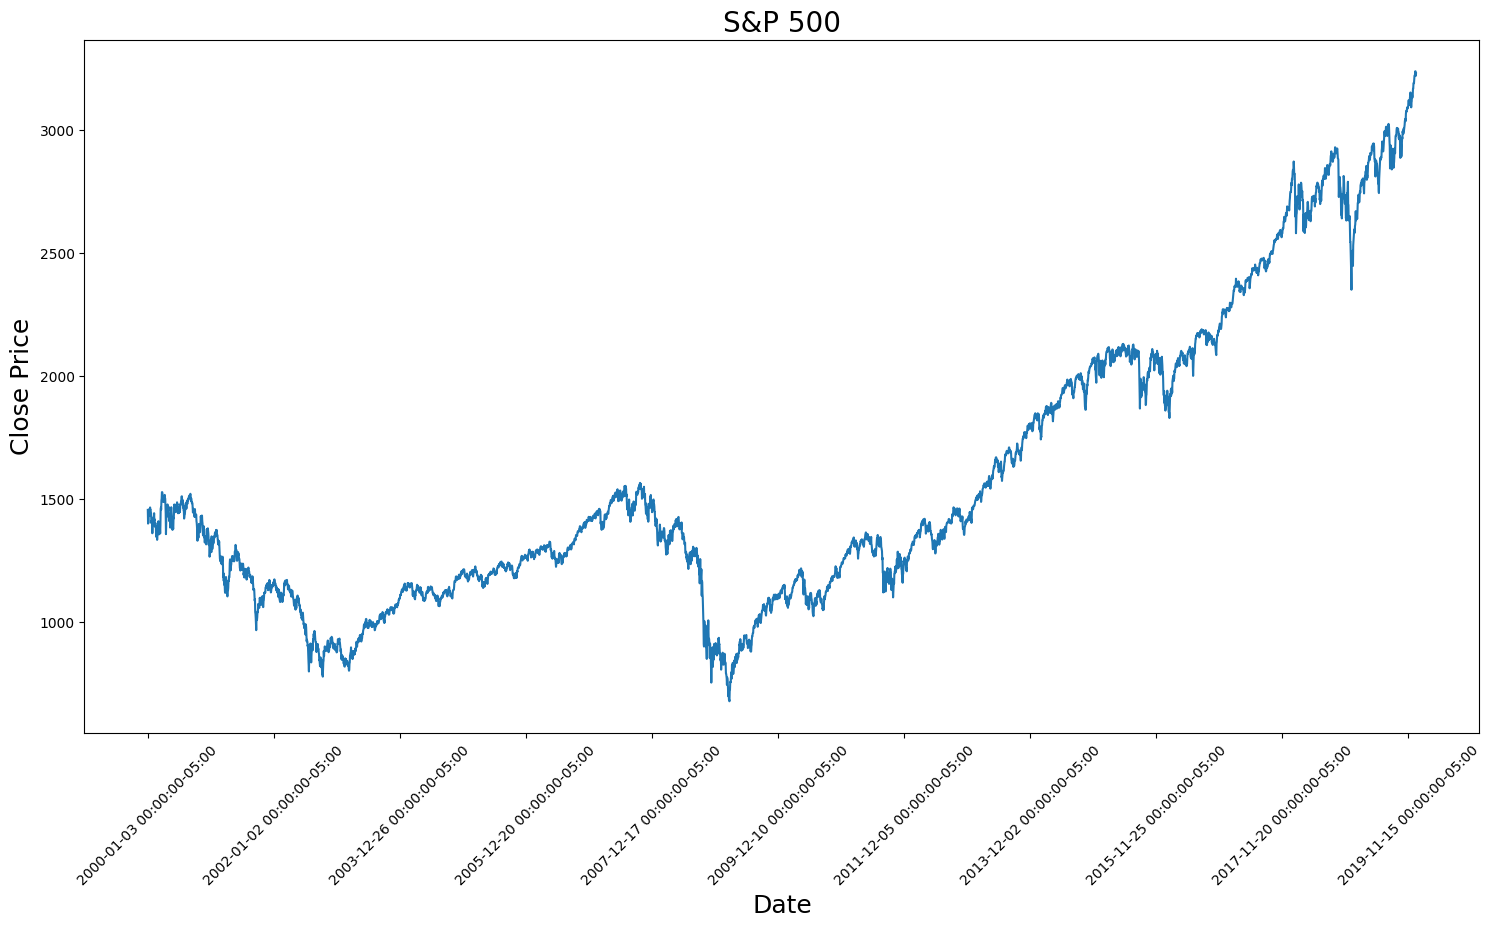

In [54]:
plt.figure(figsize = (18,9))
plt.title('S&P 500', fontsize=20)
plt.plot(range(GSPC.shape[0]), (GSPC['Close']))
plt.xticks(range(0, GSPC.shape[0], 500), GSPC.index[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [55]:
data = GSPC

In [83]:
#extract factors 
window = 50

# Calculate momentum
data['Momentum'] = data['Close'].pct_change(periods=window)

# Calculate rolling volatility
data['Volatility'] = data['Close'].rolling(window=window).std()

# Value - use P/E ratio -> find data source 

# Quality 

# Size 

#remove Nan values - first year 
counter=0
for x in data['Momentum']:
    if np.isnan(x)==1:
        counter+=1

counter

50

In [84]:
#split data into training and testing 
a = int(len(data))
b = int(a*0.7)
train_dataset = data[:b]
test_dataset = data[b:a]

In [90]:
# Split data into features (factors) and target (returns)
X = train_dataset[['Momentum', 'Volatility']]
#y = train_dataset['Close'].pct_change(periods=252).shift(-252) #annual return, percentage change 
y = train_dataset['Close'].pct_change(periods=window).shift(-window) 

# Drop NaN values in X (first window)
X = X[window:]
y = y[window:]

#Drop Nan values in y and corresponding X
X = X[~y.isna()]
y = y.dropna()


# Train the random forest model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

RandomForestRegressor()

In [98]:
class FactorStrategy(Strategy):
    
    def init(self):
        # Initialize an indicator to store predictions
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        # Prepare the latest feature data for prediction
        features = self.data.df.iloc[-1:][['Momentum', 'Volatility']]
        predicted_return = model.predict(features)[0]

        # Update forecast indicator for plotting
        self.forecasts[-1] = predicted_return

        # Implement buy/sell logic based on predicted return
        if predicted_return > 0:
            self.buy(size=0.5) #calculate best size 
            
        elif predicted_return < 0:
            self.sell(size=0.5)
            

# Run the backtest on training data 
bt = Backtest(train_dataset, FactorStrategy, cash=10000, commission=0.002)
stats = bt.run()

print(stats)
bt.plot()



Start                     2000-01-03 00:00...
End                       2013-12-31 00:00...
Duration                   5111 days 00:00:00
Exposure Time [%]                   99.943198
Equity Final [$]                 19243.348869
Equity Peak [$]                  19243.348869
Return [%]                          92.433489
Buy & Hold Return [%]               27.015848
Return (Ann.) [%]                    4.796344
Volatility (Ann.) [%]               20.096281
Sharpe Ratio                         0.238668
Sortino Ratio                        0.357206
Calmar Ratio                         0.088835
Max. Drawdown [%]                  -53.991799
Avg. Drawdown [%]                   -2.877686
Max. Drawdown Duration     1997 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                   13
Win Rate [%]                            100.0
Best Trade [%]                     130.526391
Worst Trade [%]                      5.847774
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p10580', ...)

In [94]:
#code modified from https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html
#currently not working - need to understand rules 

class FactorStrategy2(Strategy):
    price_delta = .004  # 0.4% #not sure what this is 
    
    def init(self):        
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        
        # Forecast the next movement
        features = self.data.df.iloc[-1:][['Momentum', 'Volatility']]
        predicted_return = model.predict(features)[0]
        
        # Update forecast indicator for plotting
        self.forecasts[-1] = predicted_return

        
        # Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if predicted_return > 0 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif predicted_return < 0 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(train_dataset, FactorStrategy2, commission=.0002, margin=.05)
stats = bt.run()

print(stats)
bt.plot()


Start                     2000-01-03 00:00...
End                       2013-12-31 00:00...
Duration                   5111 days 00:00:00
Exposure Time [%]                    25.84493
Equity Final [$]                   176.803443
Equity Peak [$]                       10000.0
Return [%]                         -98.231966
Buy & Hold Return [%]               27.015848
Return (Ann.) [%]                  -25.084462
Volatility (Ann.) [%]                8.424113
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.231966
Avg. Drawdown [%]                  -98.231966
Max. Drawdown Duration     5110 days 00:00:00
Avg. Drawdown Duration     5110 days 00:00:00
# Trades                                  902
Win Rate [%]                        36.585366
Best Trade [%]                       0.631735
Worst Trade [%]                     -1.267016
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p9202', ...)

#### Optimise

#### Final Evaluation

In [97]:
#run on test data 

class FactorStrategy(Strategy):
    n_train = len(train_dataset)  

    def init(self):
        # Initialize an indicator to store predictions
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        #Skip the initial training data period -> only unseen data 
        if len(self.data) < self.n_train:
            return

        # Prepare the latest feature data for prediction
        features = self.data.df.iloc[-1:][['Momentum', 'Volatility']]
        predicted_return = model.predict(features)[0]

        # Update forecast indicator for plotting
        self.forecasts[-1] = predicted_return

        # Implement buy/sell logic based on predicted return
        if predicted_return > 0:
            self.buy(size=0.5)
        elif predicted_return < 0:
            self.sell(size=0.5)

# Run the backtest on training data 
bt = Backtest(data, FactorStrategy, cash=10000, commission=0.002)
stats = bt.run()

print(stats)
bt.plot()



Start                     2000-01-03 00:00...
End                       2019-12-31 00:00...
Duration                   7302 days 00:00:00
Exposure Time [%]                   30.013914
Equity Final [$]                 15444.704341
Equity Peak [$]                  15588.125608
Return [%]                          54.447043
Buy & Hold Return [%]              122.013173
Return (Ann.) [%]                    2.201169
Volatility (Ann.) [%]                5.710985
Sharpe Ratio                         0.385427
Sortino Ratio                        0.545756
Calmar Ratio                         0.136242
Max. Drawdown [%]                  -16.156311
Avg. Drawdown [%]                   -1.147361
Max. Drawdown Duration      417 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                    3
Win Rate [%]                            100.0
Best Trade [%]                      75.121148
Worst Trade [%]                     73.835634
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p10195', ...)